In [1]:
%%capture
!pip install pydicom

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from tqdm.notebook import tqdm
import pydicom
import cv2
from pathlib import Path

from google.colab import drive
drive.mount("/content/drive")

In [2]:
zip_file = zipfile.ZipFile(file = "/content/drive/MyDrive/PyTorch_Vol3/05-Detection.zip", mode = "r")
zip_file.extractall()
zip_file.close()

In [3]:
zip_file = zipfile.ZipFile(file = "/content/drive/MyDrive/PyTorch_Vol3/rsna-pneumonia-detection-challenge.zip", mode = "r")
zip_file.extractall()
zip_file.close()

In [4]:
labels = pd.read_csv("/content/05-Detection/rsna_heart_detection.csv")
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [5]:
ROOT_PATH = Path("/content/stage_2_train_images/")
SAVE_PATH = Path("/content/Processed-Heart-Detection/")

In [6]:
print("Shape : ", labels.shape)

Shape :  (496, 8)


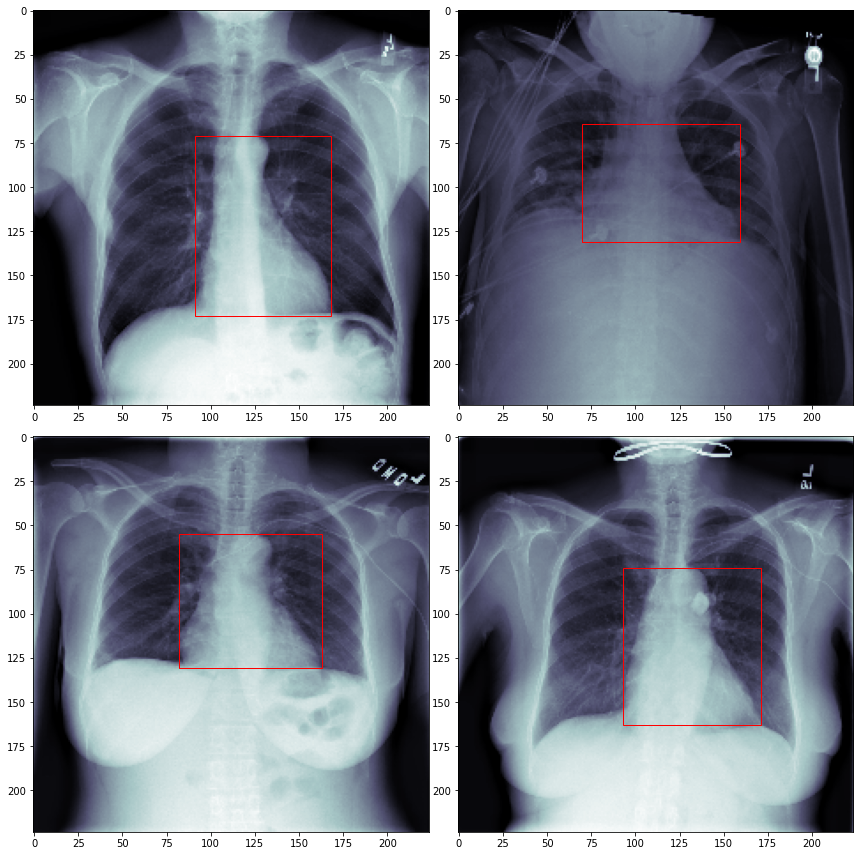

In [9]:
fig, ax = plt.subplots(2,2, figsize =(12,12))

c = 0
ax = ax.ravel()

for i in range(len(ax)):

    data = labels.iloc[c]
    patient_id = data["name"]
    dcm_path = ROOT_PATH/str(patient_id)
    dcm_path = dcm_path.with_suffix(".dcm")

    dcm = pydicom.read_file(dcm_path)
    dcm_array = dcm.pixel_array
    dcm_array = cv2.resize(dcm_array, (224,224))

    x = data["x0"]
    y = data["y0"]
    width = data["w"]
    height = data["h"]

    ax[i].imshow(dcm_array, cmap = "bone")
    rect = patches.Rectangle((x,y), width, height , linewidth = 1, edgecolor = "r", facecolor = "None")
    ax[i].add_patch(rect)
    c+=1

plt.tight_layout()
plt.show()

In [10]:
sums, sums_squared = 0, 0

train_ids = []
val_ids = []

for counter, patient_id in enumerate(tqdm(list(labels.name))):

    dcm_path = ROOT_PATH/str(patient_id)
    dcm_path = dcm_path.with_suffix(".dcm")

    dcm = pydicom.read_file(dcm_path)
    dcm_array = dcm.pixel_array
    dcm_array = cv2.resize(dcm_array, (224, 224)) / 255
    dcm_array = dcm_array.astype(np.float16)

    train_or_val = "train" if counter < 400 else "val"

    if train_or_val == "train":
        train_ids.append(patient_id)
        
    else:
        val_ids.append(patient_id)

    # Burda ..../train/patient_id yada ...../val/patient_id olarak ayrılıp ekleniyor !!!!

    current_save_path = SAVE_PATH/train_or_val
    current_save_path.mkdir(parents = True, exist_ok = True)

    np.save(current_save_path/patient_id, dcm_array)

    normalizer = 224*224

    if train_or_val == "train":

        sums +=np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer

  0%|          | 0/496 [00:00<?, ?it/s]

In [11]:
np.save("/content/Processed-Heart-Detection/train_subjects", train_ids)
np.save("/content/Processed-Heart-Detection/val_subjects", val_ids)

In [12]:
mean = sums / len(train_ids)
std = np.sqrt((sums_squared / len(train_ids)) - mean ** 2)
mean, std

(0.49430165816326493, 0.2527964897943661)

----

In [13]:
import torch
import imgaug
from imgaug.augmentables.bbs import BoundingBox

In [14]:
ROOT_PATH,SAVE_PATH

(PosixPath('/content/stage_2_train_images'),
 PosixPath('/content/Processed-Heart-Detection'))

In [15]:
class CardiacDataset(torch.utils.data.Dataset):
    
    def __init__(self,path_to_labels_csv, patients, root_path, augs):

        self.labels = pd.read_csv(path_to_labels_csv)
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):

        patient = self.patients[idx]
        data = self.labels[self.labels["name"] == patient]

        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()
        y_max = y_min + data["h"].item()

        bbox = [x_min,y_min,x_max,y_max]

        file_path = self.root_path/patient
        img = np.load(f"{file_path}.npy").astype(np.float32)

        if self.augment:

            bb = BoundingBox(x1 = bbox[0], y1 = bbox[1], x2 = bbox[2], y2 = bbox[3])
            
            random_seed = torch.randint(0,100000, (1,)).item()
            imgaug.seed(random_seed)

            img, aug_bbox = self.augment(image = img, bounding_boxes = bb)
            bbox = aug_bbox.x1, aug_bbox.y1, aug_bbox.x2, aug_bbox.y2

        img = (img - mean) / std

        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
        return img, bbox

In [17]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [18]:
seq = iaa.Sequential([
                      iaa.GammaContrast(),
                      iaa.Affine(
                          scale = (0.8, 1.2),
                          rotate = (-10, 10),
                          translate_px = (-10, 10)
                      )
])

In [19]:
labels_path = "/content/05-Detection/rsna_heart_detection.csv"
patients_path = "/content/Processed-Heart-Detection/train_subjects.npy"
train_root = "/content/Processed-Heart-Detection/train"

In [20]:
len(np.load(patients_path)),pd.read_csv(labels_path).shape, len(list(Path(train_root).glob("*")))

(400, (496, 8), 400)

In [32]:
test = labels.head(1)
x_min , y_min, w, h = test["x0"].values,test["y0"].values,test["w"].values,test["h"].values
x_max, y_max = x_min + w, y_min + h
name = test.name[0]

ex_img = np.load(train_root+"/"+str(name)+".npy").astype(np.float32)
rect = patches.Rectangle((x,y), w, h, linewidth = 1, edgecolor = "r", facecolor = "none")
x_min,y_min,w,h,x_max,y_max

(array([91]),
 array([71]),
 array([77]),
 array([102]),
 array([168]),
 array([173]))

In [33]:
ex_bb = BoundingBox(x_min, y_min, x_max, y_max)
ex_bb

BoundingBox(x1=91.0000, y1=71.0000, x2=168.0000, y2=173.0000, label=None)

In [34]:
random_seed = torch.randint(0, 100000, (1,)).item()
imgaug.seed(random_seed)

aug_img, aug_box = seq(image = ex_img, bounding_boxes = ex_bb)
aug_box

BoundingBox(x1=97.5653, y1=77.4187, x2=175.6064, y2=180.1119, label=None)

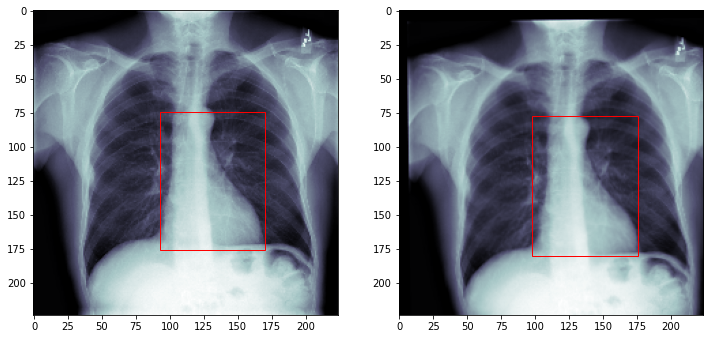

In [35]:
aug_rect = patches.Rectangle((aug_box.x1, aug_box.y1),aug_box.x2 - aug_box.x1, aug_box.y2 - aug_box.y1,
                             linewidth = 1, edgecolor = "r", facecolor = "none")

fig, ax = plt.subplots(1,2,figsize = (12,7))

ax[0].imshow(ex_img,cmap = "bone")
ax[0].add_patch(rect)

ax[1].imshow(aug_img,cmap = "bone")
ax[1].add_patch(aug_rect)

plt.show()

In [36]:
labels_path = "/content/05-Detection/rsna_heart_detection.csv"
patients_path = "/content/Processed-Heart-Detection/train_subjects.npy"
train_root = "/content/Processed-Heart-Detection/train"

In [37]:
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)
len(dataset)

400

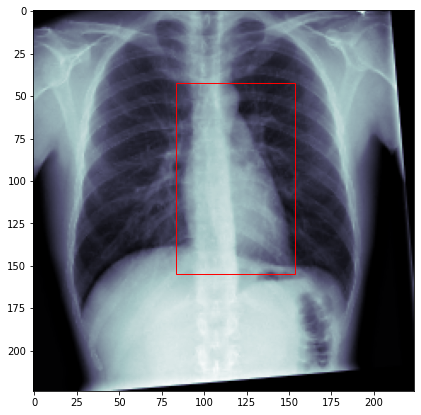

In [39]:
img, bbox = dataset[399]

fig,axis = plt.subplots(1,1, figsize = (7,7))
axis.imshow(img[0], cmap = "bone")
rect = patches.Rectangle((bbox[0] , bbox[1]), bbox[2]-bbox[0], bbox[3] - bbox[1], edgecolor = "r" , facecolor = "none")
axis.add_patch(rect)
plt.show()

----

In [40]:
train_root_path = "/content/Processed-Heart-Detection/train"
train_subjects = "/content/Processed-Heart-Detection/train_subjects.npy"

val_root_path = "/content/Processed-Heart-Detection/val"
val_subjects = "/content/Processed-Heart-Detection/val_subjects.npy"

train_transforms = iaa.Sequential([
                                   iaa.GammaContrast(),
                                   iaa.Affine(
                                       scale = (0.8, 1.2),
                                       rotate = (-10, 10),
                                       translate_px = (-10, 10)
                                   )
])

In [41]:
train_dataset = CardiacDataset("/content/05-Detection/rsna_heart_detection.csv",
                               train_subjects,
                               train_root_path,
                               train_transforms)

val_dataset = CardiacDataset("/content/05-Detection/rsna_heart_detection.csv",
                               val_subjects,
                               val_root_path,
                               None)

In [42]:
len(train_dataset),len(val_dataset)

(400, 96)

In [43]:
batch_size = 8
num_workers = 4


train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size,
                                           num_workers = num_workers,
                                           shuffle = True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size = batch_size,
                                           num_workers = num_workers,
                                           shuffle = False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [44]:
%%capture 
!pip install pytorch-lightning
!pip install torchmetrics

In [45]:
import pytorch_lightning as pl
import torchmetrics
import torchvision
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [46]:
for x, y in train_dataset:
    break

x.shape , np.array(y).shape

(torch.Size([1, 224, 224]), (4,))

In [53]:
class CardiacDetectionModel(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.model = torchvision.models.resnet18(pretrained = True)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size = (7,7), stride = (2,2), padding = (3,3), bias = False)
        self.model.fc = torch.nn.Linear(in_features = 512, out_features = 4)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, data):

        return self.model(data)

    def training_step(self, batch, batch_idx):

        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)

        self.log("Train Loss",loss)

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(),label.cpu(), "Train")

        return loss


    def validation_step(self, batch, batch_idx):

        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)

        self.log("Val Loss",loss)

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(),label.cpu(), "Val")

        return loss

    def log_images(self,x_ray,pred,label,name):

        results = []

        for i in range(4):

            coords_labels = label[i]
            coords_pred = pred[i]

            img = ((x_ray[i] * std) + mean).numpy()[0]

            x0,y0 = coords_labels[0].int().item() , coords_labels[1].int().item()
            x1,y1 = coords_labels[0].int().item() , coords_labels[1].int().item()
            img = cv2.rectangle(img, (x0,y0), (x1,y1),(0,0,0),2)


            x0,y0 = coords_pred[0].int().item() , coords_pred[1].int().item()
            x1,y1 = coords_pred[0].int().item() , coords_pred[1].int().item()
            img = cv2.rectangle(img, (x0,y0), (x1,y1),(0,0,0),2)

            results.append(torch.tensor(img).unsqueeze(0))
        
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)

    def configure_optimizers(self):
        return [self.optimizer]

In [54]:
model = CardiacDetectionModel()

In [55]:
checkpoint_callback = ModelCheckpoint(
    monitor = "Val Loss",
    save_top_k = 10,
    mode = "min"
)

In [56]:
gpus = 0
trainer = pl.Trainer(gpus = gpus, logger = TensorBoardLogger("./logs"),
                     log_every_n_steps = 1, default_root_dir = "./weights",
                     callbacks = checkpoint_callback, max_epochs = 100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [57]:
trainer.fit(model, train_loader, val_loader)


  | Name    | Type    | Params
------------------------------------
0 | model   | ResNet  | 11.2 M
1 | loss_fn | MSELoss | 0     
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


-----

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.load_from_checkpoint("/content/05-Detection/weight.ckpt")
model.eval()
model.to(device)

CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [59]:
preds = []
labels = []

with torch.no_grad():
    for data , label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred =  model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)

  0%|          | 0/96 [00:00<?, ?it/s]

In [60]:
len(preds),len(labels)

(96, 96)

In [63]:
preds = torch.stack(preds)
labels = torch.stack(labels)

preds.shape,labels.shape

(torch.Size([96, 4]), torch.Size([96, 4]))

In [64]:
abs(preds - labels).mean(0)

tensor([8.3373, 5.5588, 5.9845, 5.7304])

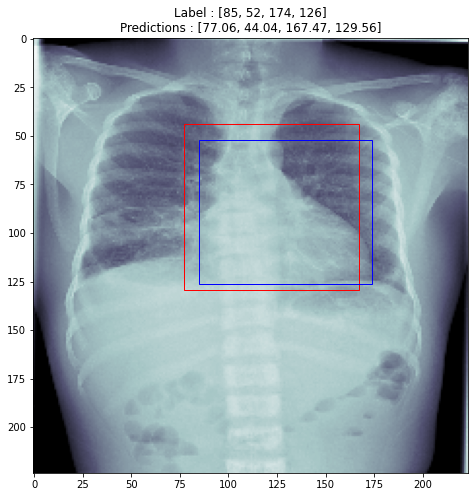

In [79]:
IDX = 60

img, label = val_dataset[IDX]
pred = preds[IDX]
label = labels[IDX]

fig, axis = plt.subplots(1,1,figsize = (8,8))
axis.imshow(img[0],cmap = "bone")

heart_pred = patches.Rectangle((pred[0],pred[1]), pred[2] - pred[0], pred[3] - pred[1] , edgecolor = "r", facecolor = "none")
heart_orj = patches.Rectangle((label[0],label[1]), label[2] - label[0], label[3] - label[1] , edgecolor = "b", facecolor = "none")

axis.add_patch(heart_pred)
axis.add_patch(heart_orj)

axis.set_title(f"Label : {[np.round(i.item(),5) for i in labels[IDX]]}\nPredictions : {[np.round(i.item(),2) for i in preds[IDX]]}")
plt.show()

In [72]:
[i.item() for i in preds[60]]

[77.06348419189453, 44.03694534301758, 167.46649169921875, 129.56161499023438]